In [19]:
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
from tqdm import tqdm, trange
from glob import glob 
import segment_every_grain as seg
import os
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

## Create patches from large images

In [ ]:
image_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/images/'
mask_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/labels/'
dirname = '/Users/zoltan/Dropbox/Segmentation/images/'
images = sorted(glob(dirname + "*image*"))
labels = sorted(glob(dirname + "*mask*"))

start_no = 0
for image in tqdm(images):
    # Load the large image
    large_image = tf.keras.preprocessing.image.load_img(image)
    # Convert the image to a tensor
    large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 3])
    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,:]).astype('uint8')
        imname = image_dir + 'im%03d.png'%(start_no + i)
        im = Image.fromarray(im.astype(np.uint8))
        im.save(imname)
    start_no = start_no + patches.shape[0]
    
start_no = 0
for image in tqdm(labels):
    # Load the large image
    large_image = tf.keras.preprocessing.image.load_img(image)
    # Convert the image to a tensor
    large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    large_image = large_image[:,:,0,np.newaxis] # only keep one layer and add a new axis
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 1])
    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,0]).astype('uint8')
        imname = mask_dir + 'im%03d.png'%(start_no + i)
        im = Image.fromarray(im.astype(np.uint8))
        im.save(imname)
    start_no = start_no + patches.shape[0]

## Create training, validation, and test sets

In [5]:
image_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/images/'
mask_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/labels/'
image_files = sorted(glob(os.path.join(image_dir, '*.png')))
mask_files = sorted(glob(os.path.join(mask_dir, '*.png')))

batch_size = 32
shuffle_buffer_size = 1000

# split half into training
train_idx = np.random.choice(np.arange(len(image_files)), size = int(len(image_files)/2) , replace=False)
# get the rest
idx = np.setdiff1d(np.arange(len(image_files)), train_idx)
# get val files (25% of total)
val_idx = np.random.choice(idx, size = int(len(image_files)/4) , replace=False)
# get test files (25% of total)
test_idx = np.setdiff1d(val_idx, train_idx)

# create arrays of training, validation, and test files (these are filenames)
train_images = np.array(image_files)[train_idx]
val_images = np.array(image_files)[val_idx]
test_images = np.array(image_files)[test_idx]

train_masks = np.array(mask_files)[train_idx]
val_masks = np.array(mask_files)[val_idx]
test_masks = np.array(mask_files)[test_idx]

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_dataset = train_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val_dataset = val_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
test_dataset = test_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Metal device set to: Apple M2 Max


2023-05-24 04:28:55.838325: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-24 04:28:55.838487: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


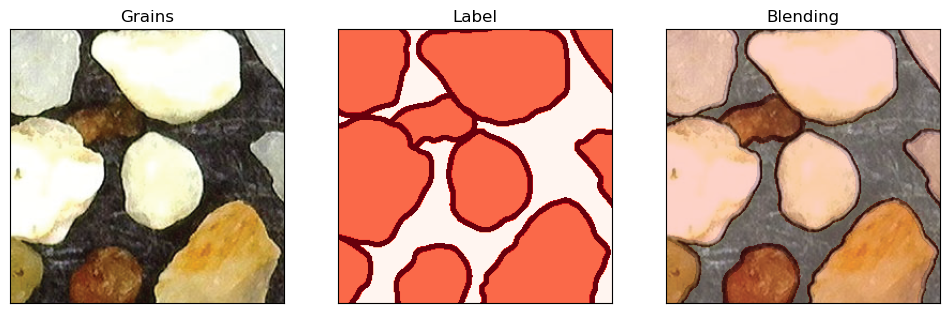

In [9]:
# check how masks look like
fname = train_images[1002]
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # need to convert from BGR to RGB
mask = cv2.imread(fname.replace('images', 'labels'))
seg.plot_images_and_labels(img, mask)

## Build, train, and evaluate model

In [12]:
model = seg.Unet()
model.compile(optimizer=Adam(), loss=seg.weighted_crossentropy, metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

 concatenate_2 (Concatenate)    (None, 128, 128, 64  0           ['conv2d_transpose_2[0][0]',     
                                )                                 'batch_normalization_1[0][0]']  
                                                                                                  
 conv2d_14 (Conv2D)             (None, 128, 128, 32  18464       ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 128, 128, 32  128        ['conv2d_15[0][0]']              
 rmalizati

In [13]:
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)

Epoch 1/50


2023-05-24 11:48:35.697068: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-24 11:48:35.697290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.8837 - accuracy: 0.7158

2023-05-24 11:49:05.005138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - 35s 189ms/step - loss: 0.8837 - accuracy: 0.7158 - val_loss: 1.1948 - val_accuracy: 0.5737
Epoch 2/50
160/160 [==============================] - 28s 174ms/step - loss: 0.7988 - accuracy: 0.8100 - val_loss: 1.2274 - val_accuracy: 0.6219
Epoch 3/50
160/160 [==============================] - 28s 175ms/step - loss: 0.7687 - accuracy: 0.8401 - val_loss: 0.8746 - val_accuracy: 0.7207
Epoch 4/50
160/160 [==============================] - 29s 177ms/step - loss: 0.7521 - accuracy: 0.8563 - val_loss: 0.8393 - val_accuracy: 0.8326
Epoch 5/50
160/160 [==============================] - 28s 173ms/step - loss: 0.7403 - accuracy: 0.8688 - val_loss: 0.7628 - val_accuracy: 0.8736
Epoch 6/50
160/160 [==============================] - 28s 174ms/step - loss: 0.7328 - accuracy: 0.8758 - val_loss: 0.8289 - val_accuracy: 0.7539
Epoch 7/50
160/160 [==============================] - 28s 174ms/step - loss: 0.7491 - accuracy: 0.8582 - val_loss: 0.7883 - val_accuracy: 0.8

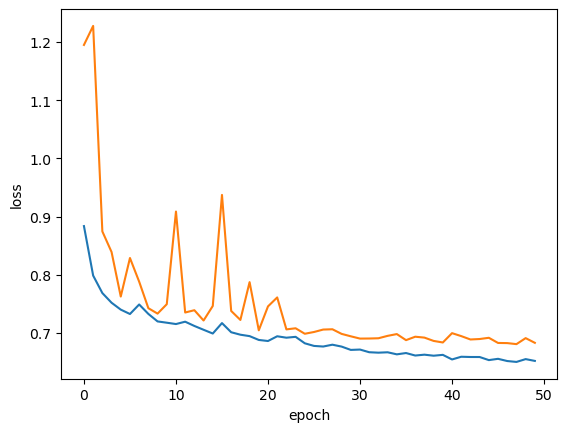

In [22]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss');

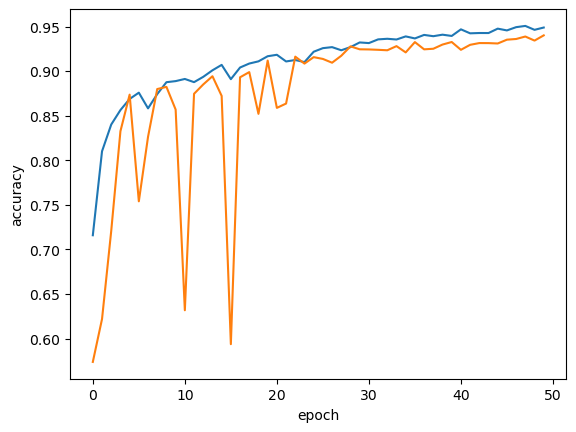

In [23]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy');

In [24]:
model.evaluate(test_dataset)

80/80 [==============================] - 6s 60ms/step - loss: 0.6833 - accuracy: 0.9401


[0.6832899451255798, 0.9401033520698547]

In [ ]:
model.save_weights('model.h5')